# Michele Banfi 869294 - EX 02

This exercise consists in implementing a quantum circuit that sums two positives numbers $n_1$ and $n_2$ in a quantum computer. The circuit will sum the number on the qubits representing the first number. So for example $a$ and $b$ will output $a+b$ and $b$ will be left unchanged. The circuit will be implemented in Qiskit. 

In [1]:
# import libraries
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.visualization import circuit_drawer
import numpy as np

In [2]:
# define the numbers to be summed in decimal notation
n1 = 2
n2 = 9

# be aware that the summation will be cyclic, so the result will be the sum modulo <number_of_bits>

In [3]:
# encode n1 and n2 in binary
n1_bin = np.binary_repr(n1)
n2_bin = np.binary_repr(n2)

print(f"Binary representation of {n1} is: {n1_bin}")
print(f"Binary representation of {n2} is: {n2_bin}")

Binary representation of 2 is: 10
Binary representation of 9 is: 1001


In [4]:
# the two numbers must have the same length, so we add zeros to the left of the shorter number, to match the length of the longer number
if len(n1_bin) > len(n2_bin):
    n2_bin = '0'*(len(n1_bin) - len(n2_bin)) + n2_bin
else:
    n1_bin = '0'*(len(n2_bin) - len(n1_bin)) + n1_bin
    
# save for later the dimension of the binary representation
n_dim = len(n1_bin)

print(f"Normalized - Binary representation of {n1} is: {n1_bin}")
print(f"Normalized - Binary representation of {n2} is: {n2_bin}")

Normalized - Binary representation of 2 is: 0010
Normalized - Binary representation of 9 is: 1001


In [5]:
# we need double the number of qubits to represent the sum of the two numbers
circuit_qubits = n_dim * 2
qc = QuantumCircuit(circuit_qubits, n_dim)

# we need to encode the binary numbers in the qubits, we apply a cnot gate to each qubit that is 1
# initialize the first n qubits with n1 and the last n qubits with n2.
# the notation is a little bit misleading, image 3 bit, so:
# - len(n1_bin) = 3
# - len(n2_bin) = 3
# We need to correctly iterate with the indeces so the from the end to the start of the array. But remember that the indeces of an array are 0-based.
for i in range(n_dim):
    if n1_bin[n_dim - 1 -i] == '1':
        qc.x(i)
    if n2_bin[n_dim - 1 -i] == '1':
        qc.x(i + n_dim)

# logic barrier to better visualize later the circuit
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=8, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(8, 'q'), 0), Qubit(QuantumRegister(8, 'q'), 1), Qubit(QuantumRegister(8, 'q'), 2), Qubit(QuantumRegister(8, 'q'), 3), Qubit(QuantumRegister(8, 'q'), 4), Qubit(QuantumRegister(8, 'q'), 5), Qubit(QuantumRegister(8, 'q'), 6), Qubit(QuantumRegister(8, 'q'), 7)), clbits=())

Now the concept is that each qubit of the second number controls a series of cnot gates, which can be controlled also by other qubits. The least significant bit will affect all the others, and the most significant bit will affect only the least significant bit.

In [6]:
# the process of applying the cnot gates can be generalized in a function to recycle the code
# for each of the bits of the second number, which are here defined as control, we apply the circuit
def apply_cnots(qc, control):
    
    # the iteration starts from the control till the most significant bit
    counter = 0
    for _ in range(control, n_dim):
        
        # create an array of qubits controlling the cnot gate. Which in this case are:
        # - the n_qubit of the second number 
        # - all the qubits of the first number from the control to the most significant bit
        control_qubits = [control + n_dim] + list(range(control, n_dim - counter - 1))
        if (n_dim - counter - 1) in control_qubits:
            control_qubits.remove(n_dim - counter - 1)
            
        qc.mcx(control_qubits, n_dim - counter - 1)
        counter += 1
        
    qc.barrier()

In [7]:
# apply the cnot gates
for i in range(n_dim):
    apply_cnots(qc, i)

In [8]:
# measure the first n_dim qubits
qc.measure(range(n_dim), range(n_dim))

In [9]:
# run the circuit
result = Sampler().run([qc], shots=1).result()[0]
quasi_dist = result.data.c.get_counts()

# take the value of the dictionary
for key in quasi_dist:
    result = key
    break
    
print(f"Binary of the result: {result}")

# convert the result in decimal
result = int(result, 2)
print(f"Decimal of the result: {result}")

Binary of the result: 1011
Decimal of the result: 11


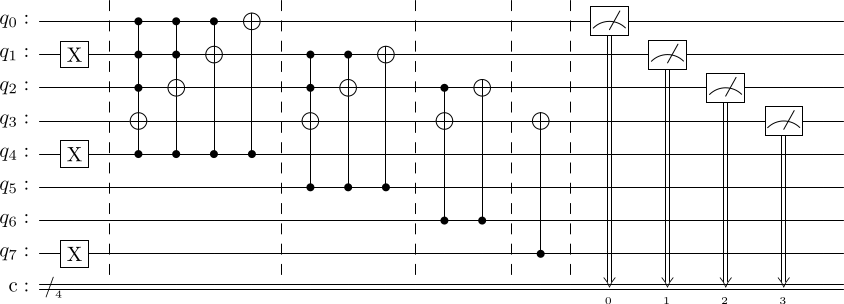

In [10]:
# print(qc)
circuit_drawer(qc, output='latex')

In [11]:
# assert that the result is correct in modulo 2**n_dim
assert result == (n1 + n2) % 2**n_dim